In [1]:
import time
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
post = pd.read_csv('../data/post.csv',encoding='utf-8-sig')
post.shape

(178874, 8)

In [3]:
comment = pd.read_csv('../data/comment.csv',encoding='utf-8-sig')
comment.shape

(188790, 7)

In [4]:
post_join = pd.DataFrame()
post_join['post_id'] = post['id']
post_join['thread_id'] = post['thread_id']

In [5]:
comment = comment.join(post_join.set_index('post_id'), on='post_id')


In [6]:
comment.dropna(subset=['thread_id'],inplace=True)

In [7]:
data = pd.concat([post,comment])
data.dropna(subset=['portrait'],inplace=True)

In [8]:
posting_data = pd.DataFrame()
posting_data['portrait'] = data['portrait']
posting_data['time'] = data['time']
posting_data['thread_id'] = data['thread_id']
posting_data[:10]

,portrait,time,thread_id
2,tb.1.7c94352b.Ob-0wPepdR8ZRNYXaNwwLw,22/4/2006 23:27:00,95018307.0
3,tb.1.ce88ae38.Im75Uw5QVEPjZiSyv8-KHw,23/4/2006 11:22:00,95018307.0
4,tb.1.bc9accf6.dsapYz8KQsA-nru6pV1bfA,23/4/2006 14:25:00,95018307.0
11,tb.1.1f9cd488.1Y1dxwREErfQXBuuTnd6sA,5/9/2006 17:06:00,95018307.0
13,tb.1.3cb7966f.G_JLsm4-cWfdqhSlWHB84A,30/9/2006 00:55:00,95018307.0
14,tb.1.1f9cd488.1Y1dxwREErfQXBuuTnd6sA,30/9/2006 10:13:00,95018307.0
15,tb.1.cfe285d3.3GD5H4nMQi2hV5EujPGx_g,30/9/2006 11:53:00,95018307.0
20,tb.1.7bb460ca.afHEiF3-e-13KKKADSgc3Q,13/1/2007 16:48:00,95018307.0
23,tb.1.e93230da.qRM7kVo7fhDbj0JHav_5lw,17/3/2007 21:48:00,95018307.0
24,tb.1.edcd4a4f.BgVkWRk4SqydlDHlkeAZQw,18/3/2007 00:54:00,95018307.0


In [9]:
user_char = pd.read_csv('../data/user_character400.csv',encoding='utf-8')
thread_char = pd.read_csv('../data/thread_character2000.csv',encoding='utf-8')

In [10]:
threads = set(thread_char['thread_id'])
users = set(user_char['portrait'])

In [11]:
posting_data.shape

(367549, 3)

In [12]:
posting_data = posting_data[posting_data.portrait.isin(users)]
posting_data.shape

(4091, 3)

In [13]:
posting_data = posting_data[posting_data.thread_id.isin(threads)]
posting_data.shape

(3681, 3)

In [14]:
posting_data.to_csv('../data/posting_data400_2000.csv',encoding='utf-8-sig',index=False)

In [15]:
def timestamp(t):
    timearray = time.strptime(t,"%d/%m/%Y %H:%M:%S")
    stamp = time.mktime(timearray)
    return stamp
stamp = []
for t in posting_data['time']:
    t = timestamp(t)
    stamp.append(t)

In [16]:
posting_data['timestamp'] = stamp

In [17]:
def normalize(max,min,x):
    y = (x-min)/(max-min)
    return y

In [18]:
def emotion_inconsistency(role,thread):
    s = thread_char[thread_char['thread_id'] == thread]['clu_result'].values[0]
    w1 =(role-s)**2
    w = w1/4
    return w

In [19]:
def forget_emotion(t0,t1,portrait):
    user = posting_data[posting_data['portrait']==portrait]
    t_new = user['timestamp'].max()
    lam = math.log(0.5, math.e)/t0
    role = user_char[user_char['portrait']==portrait]['clu_result'].values[0]
    A = []
    G = []
    F = []
    Emotion = []
    # Weight = []
    for r in user.iterrows():
        row = r[1]
        delta_t = t_new-row['timestamp']
        g = math.exp(lam*t1*int(delta_t/t1))
        a =user[user["thread_id"]==row['thread_id']]["thread_id"].count()
        if a>10:
            a = 10
        if role != 0:
            e = emotion_inconsistency(role,row['thread_id'])
        else:
            e = 0
        f = a*g
        # final_weight = gama*e+(1-gama)*f
        A.append(a)
        G.append(g)
        F.append(f)
        Emotion.append(e)
        # Weight.append(final_weight)

    user = user.copy()
    user.loc[:,'A'] = A
    user.loc[:,'G'] = G
    user.loc[:,'F'] = F
    user.loc[:,'Emotion'] = Emotion
    # user.loc[:,'Weight'] = Weight
    user.sort_values(by="timestamp",ascending=False,inplace=True)
    user.drop_duplicates(subset=['thread_id'],keep='first',inplace=True)
    return user

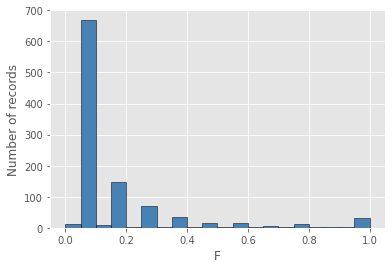

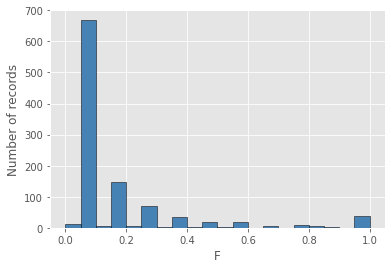

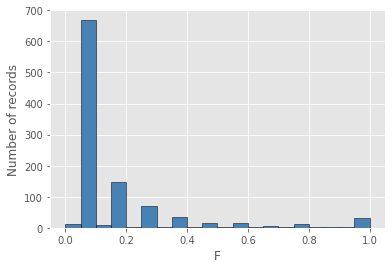

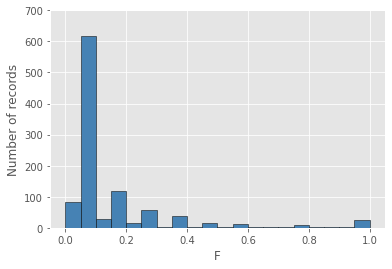

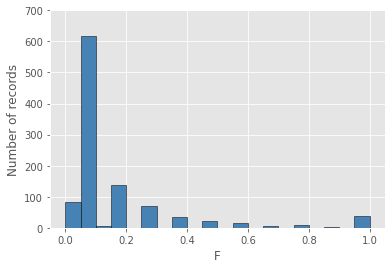

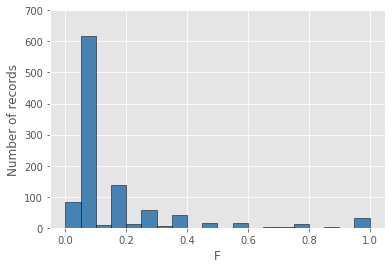

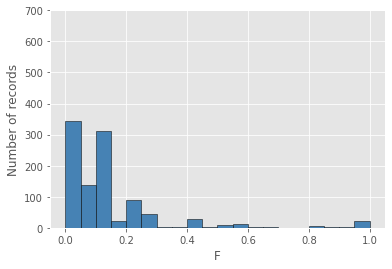

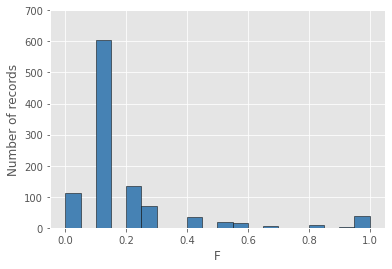

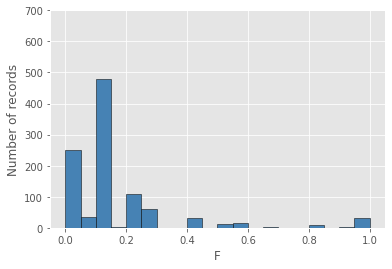

In [22]:
T0 = {30,180,720}
T1 = {3,60,180}
day = 60*60*24
# t0 = 15552000 # 180days
# t1 = 5184000 # 60days 2592000
i = 0
gama = 0.6


for t0 in T0:
    for t1 in T1:
        ut_matrix = pd.DataFrame(columns=['portrait','time','thread_id','timestamp','A','G','F','Emotion'])
        for u in users:
            u_matrix= forget_emotion(t0*day,t1*day,u)
            ut_matrix = pd.concat([ut_matrix,u_matrix])
            i += 1
            if i%1000 ==0:
                print(i,'/',len(users))
        max = ut_matrix['F'].max()
        min = ut_matrix['F'].min()
        stand_emotion = []
        for i in ut_matrix['F']:
            w = normalize(max,min,i)
            stand_emotion.append(w)
        ut_matrix['F'] = stand_emotion
        ut_matrix['weight'] = gama*ut_matrix['Emotion']+(1-gama)*ut_matrix['F']
        ut_matrix.to_csv('../data/user_thread_character400_2000_{}_{}.csv'.format(t0,t1),
                         encoding='utf-8-sig',index=False)

        plt.style.use('ggplot')
        plt.ylim(0, 700)
        plt.hist(x = ut_matrix['F'], # 指定绘图数据
         bins = 20, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
        # 添加x轴和y轴标签
        plt.xlabel('F')
        plt.ylabel('Number of records')
        plt.savefig('F_user_thread_{}_{}.png'.format(t0,t1))
        plt.show()

In [25]:
ut_matrix = pd.read_csv('../data/user_thread_character400_2000_180_60.csv',encoding='utf-8-sig')


In [26]:
ut_matrix['F'].describe()





count    1044.000000
mean        0.182921
std         0.202952
min         0.000000
25%         0.100000
50%         0.100000
75%         0.200000
max         1.000000
Name: F, dtype: float64